# Presto
## A sheet music interpreter for novice music learners
### By Elisabeth Holm and Bryant Perkins

Note: compatible with Python 3.9 or above

### User-Intialized global variables

In [2]:
# image file to process
input_file = 'sheet_music/Mary_Had_A_Little_Lamb.png'  # good for line id, can id most notes
# input_file = 'sheet_music/The_Entertainer.png' # works terribly for remove_horizontal2 but can somewhat id notes
# input_file = 'sheet_music/Somebody_to_love.png'  # great for note id without processing
# input_file = 'sheet_music/Irish_Washerwoman.jpeg'

# User-identified key signature
key_signtaure = "C"  
time_signature = (4, 4)  #4/4 time signature

### Import necessary libraries

In [3]:
# Setup
import preprocess as pp
import interpret as interp
import annotate as anno
import musics
import matplotlib.pyplot as plt
import cv2
import os

%matplotlib inline
plt.rcParams['figure.figsize'] = (25.0, 20.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2

In [4]:
# check correct file type 
# note: currently only accepts image filetypes that cv2.imread supports, 
# found here https://docs.opencv.org/4.x/d4/da8/group__imgcodecs.html

filename, file_ext = os.path.splitext(input_file)

if file_ext not in ['.png', '.jpeg', '.jpg']:
    raise Exception(f"Incorrectly formatted input file \"{input_file}\". Please input an image. \n \nIf you have a pdf, you can easily convert it to a png through the following site: https://pdf2png.com/ \n \nIf you have a physical copy, use a photo scanning app such as the notes app to create a PDF, then convert to an image file (eg png).")

### Preprocess image
Filter image

In [5]:
# reads input file as a numpy image
# returns various forms of the image (original, gray, gaussian smoothed, black and white)
orig_img, img, smoothed, black_white = pp.filter_img(input_file)

# take staff lines out of image
img_no_horizontal, img_no_hor_no_repair = pp.remove_horizontal2(orig_img.copy(), img)
# take vertical lines out of image
img_no_hor_no_ver = pp.remove_vertical(img_no_horizontal)

### Find Key Features
find staff lines and notes, gather useful data from image

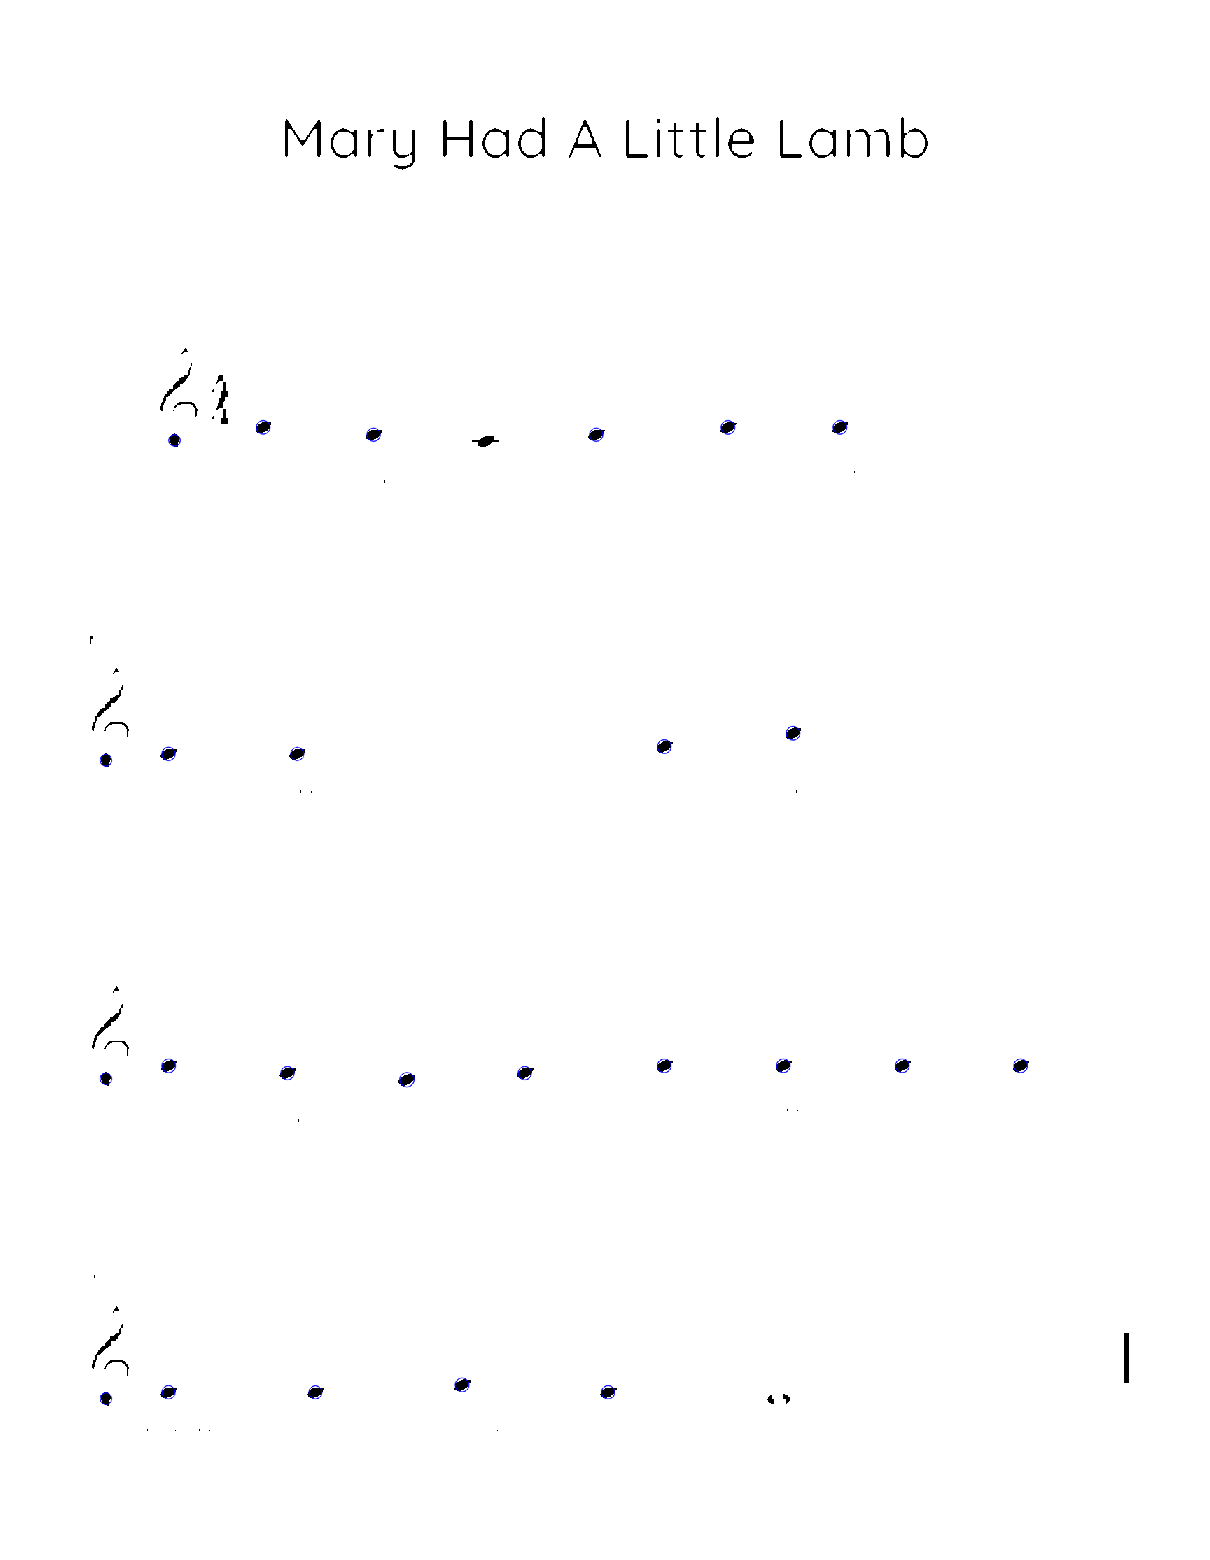

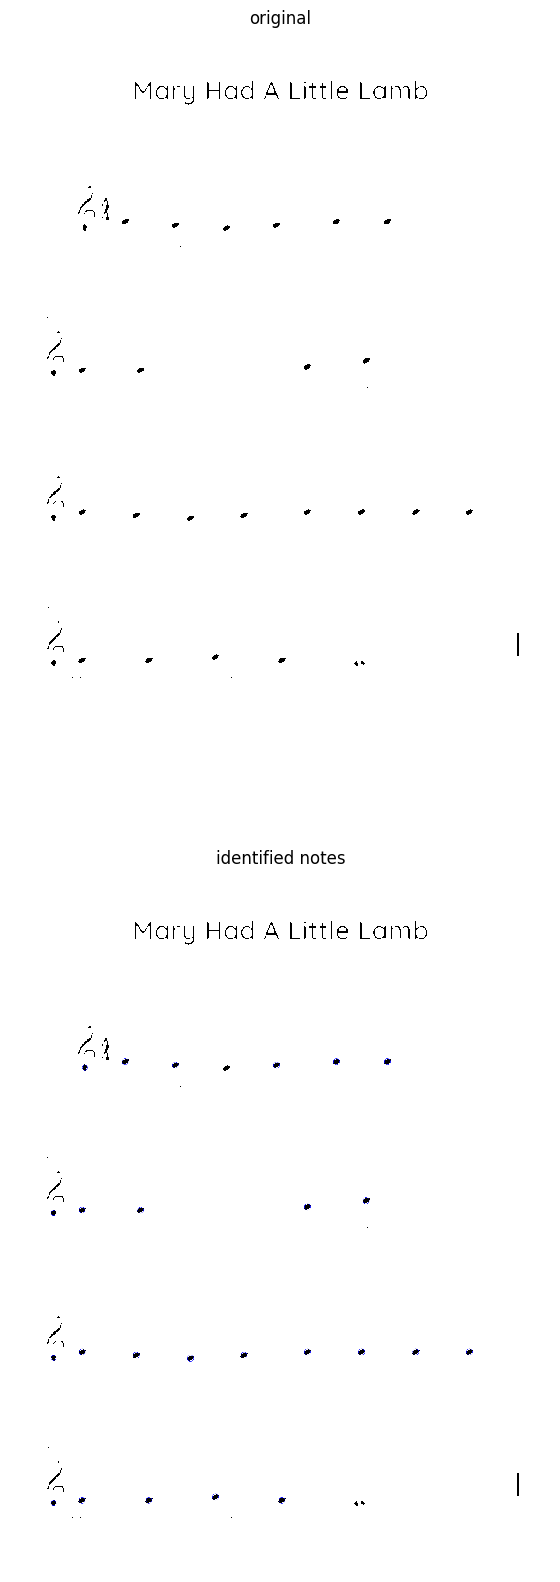

found 25 notes


In [6]:
# identify horizontal staff lines
hor_lines = pp.horizontal_canny(img.copy())
base_lines, gap_size = pp.get_base_lines(img, hor_lines)

# Finds blobs of notes in image
blobs = pp.find_blobs(img_no_hor_no_ver, display=True)

# create note objects and assign x, y attributes
note_objs = pp.create_note_objs(blobs)
print(f'found {len(note_objs)} notes')

# crop all blobs to images of individual notes
# return list of cropped images
cropped_note_imgs = pp.get_cropped_notes(blobs, img_no_hor_no_repair, save=False)

### Interpret
Interpret gathered staff and note data, turning positional pixel data into musical notation


0: 64x64 Eigth 1.00, Half 0.00, Whole 0.00, Sixteenth 0.00, Quarter 0.00, 1: 64x64 Quarter 0.95, Eigth 0.02, Whole 0.02, Half 0.01, Sixteenth 0.00, 2: 64x64 Quarter 0.97, Eigth 0.02, Whole 0.01, Half 0.00, Sixteenth 0.00, 3: 64x64 Quarter 0.95, Eigth 0.02, Whole 0.02, Half 0.01, Sixteenth 0.00, 4: 64x64 Quarter 0.86, Eigth 0.08, Half 0.03, Sixteenth 0.03, Whole 0.00, 5: 64x64 Quarter 0.82, Eigth 0.11, Sixteenth 0.04, Half 0.03, Whole 0.00, 6: 64x64 Eigth 0.99, Half 0.00, Whole 0.00, Sixteenth 0.00, Quarter 0.00, 7: 64x64 Quarter 0.97, Eigth 0.02, Half 0.00, Sixteenth 0.00, Whole 0.00, 8: 64x64 Quarter 0.97, Eigth 0.02, Half 0.00, Sixteenth 0.00, Whole 0.00, 9: 64x64 Quarter 0.90, Eigth 0.05, Half 0.03, Sixteenth 0.02, Whole 0.00, 10: 64x64 Quarter 0.90, Eigth 0.05, Half 0.03, Sixteenth 0.02, Whole 0.00, 11: 64x64 Quarter 0.90, Eigth 0.05, Half 0.03, Sixteenth 0.02, Whole 0.00, 12: 64x64 Quarter 0.77, Eigth 0.14, Sixteenth 0.05, Half 0.04, Whole 0.00, 13: 64x64 Quarter 0.77, Eigth 0.14

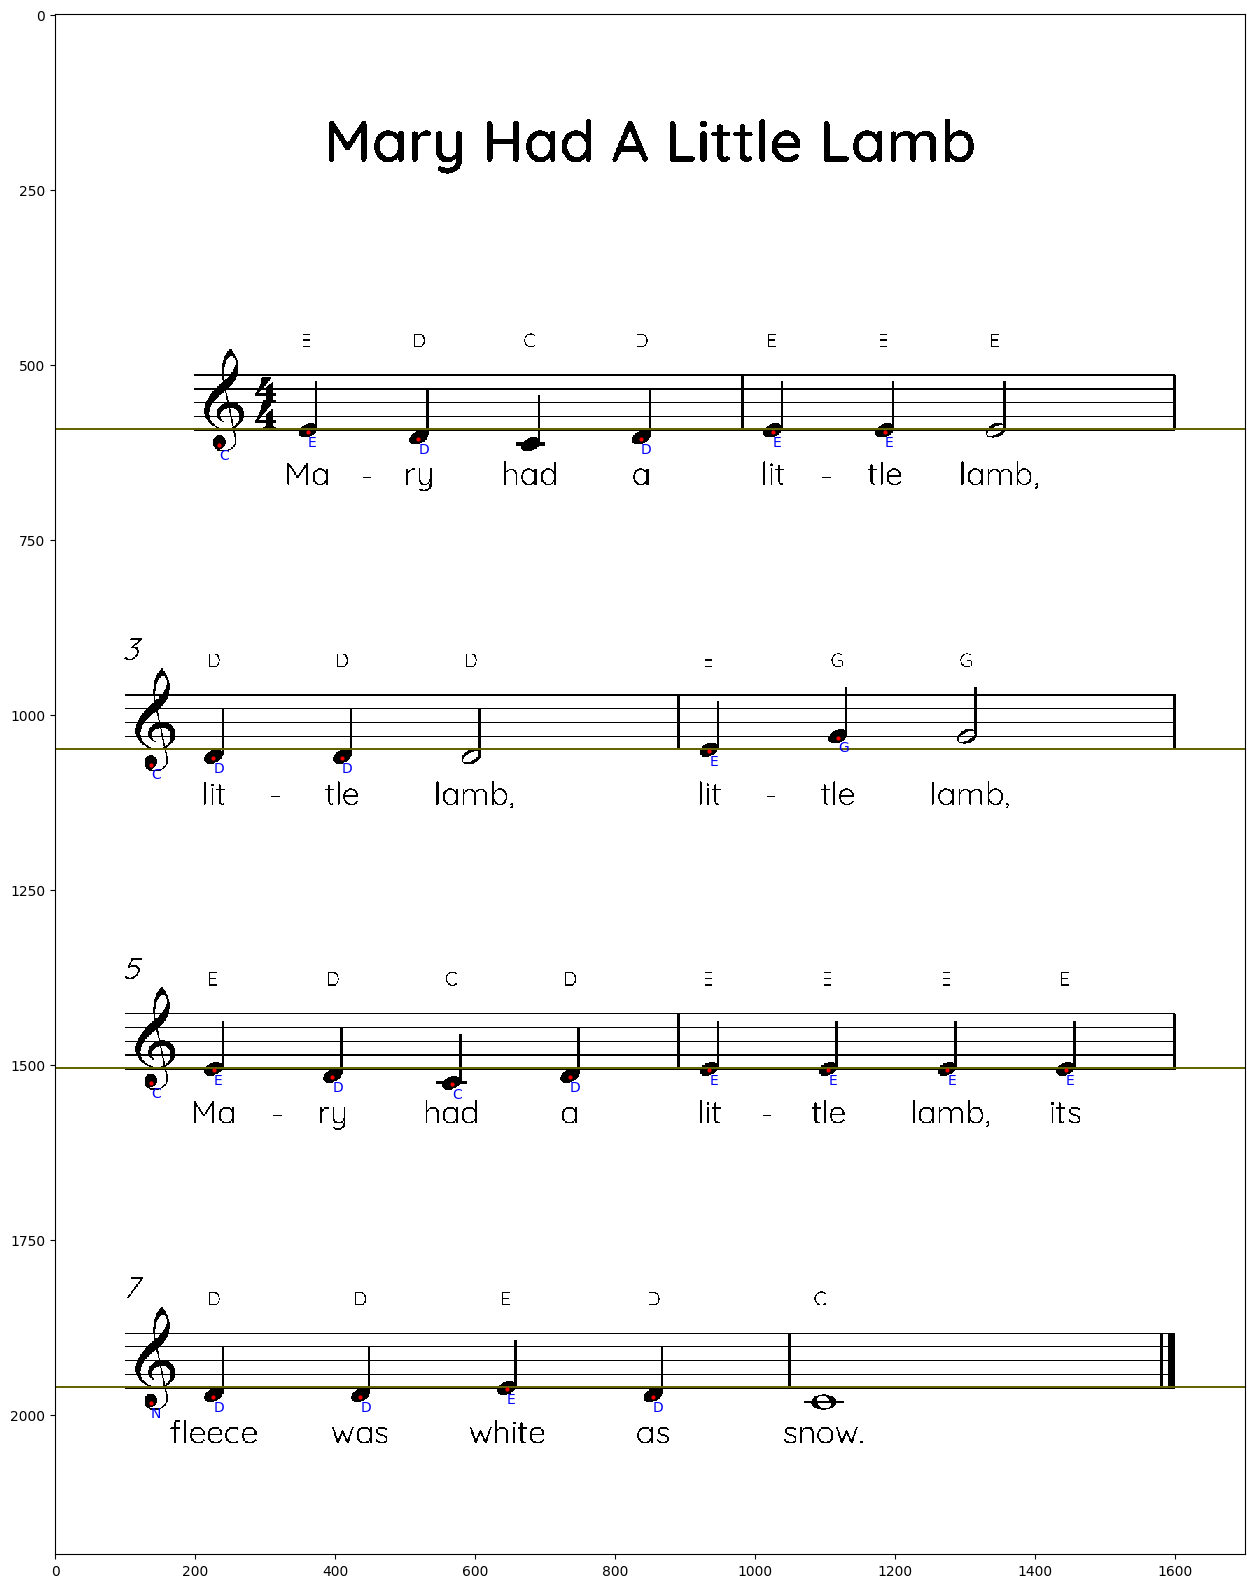

In [10]:
# elisabeth's copy for testing
# load trained YOLO model
model = interp.initialize_model()
# predict time of all notes
interp.predict_note_times(model, cropped_note_imgs, note_objs)

# identify the letter of each note based on its position relative to the staff lines
interp.config_notes(base_lines, note_objs, gap_size)

# show identified lines
test = orig_img.copy()
for line in base_lines:
    cv2.line(test, (0, line), (2000, line), (100, 100, 0), 2)
plt.imshow(test)

# print note properties for each note
# for note in note_objs:
#     note.debug_info()
#     print()

# show identified notes
for note in note_objs:
    # print(f"x: {note.x}, y: {note.y}, note: {note.key}")
    plt.plot(note.x, note.y, 'ro', markersize=2)
    plt.text(note.x, note.y + 20, note.time, color="blue")

x: 700, y: 510, note: F
x: 800, y: 520, note: E
x: 700, y: 531, note: D
x: 800, y: 541, note: C
x: 700, y: 552, note: B
x: 800, y: 562, note: A
x: 700, y: 573, note: G
x: 800, y: 583, note: F
x: 700, y: 594, note: E
x: 800, y: 604, note: D
x: 700, y: 615, note: C
x: 800, y: 625, note: N
x: 700, y: 636, note: N
x: 800, y: 646, note: N


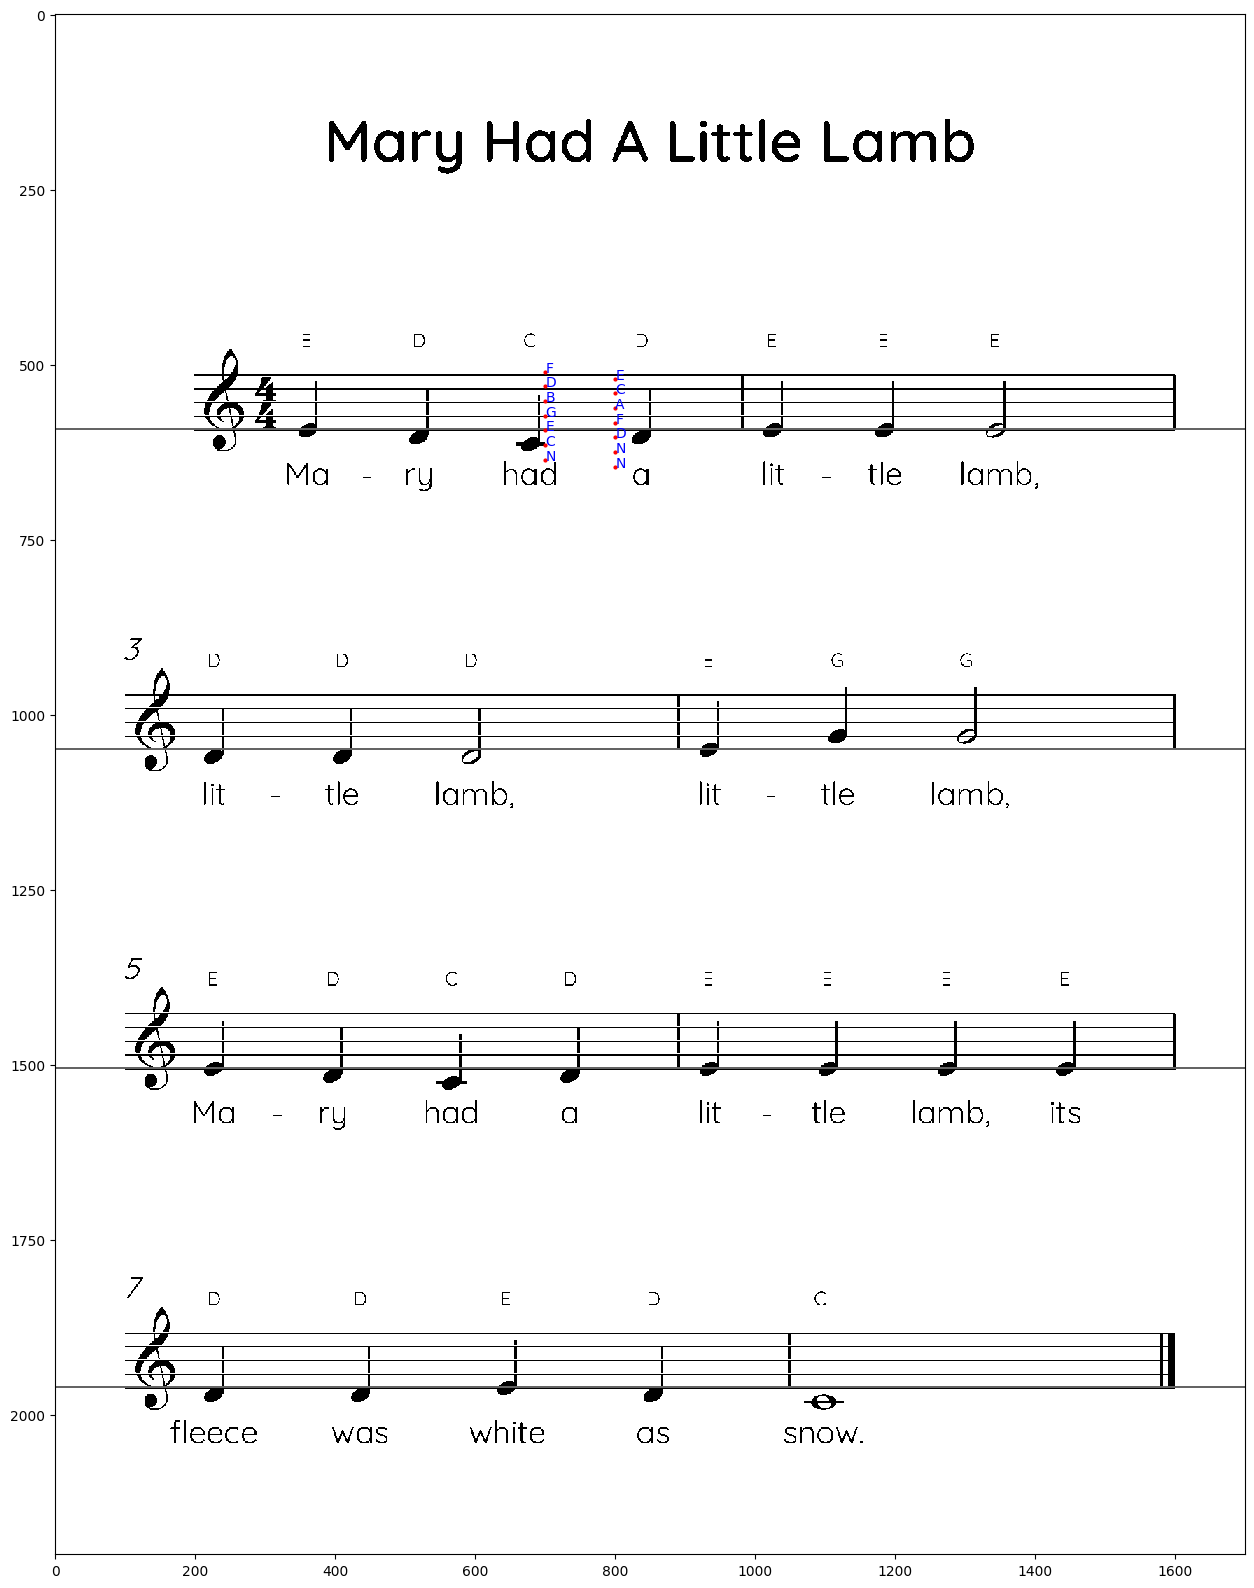

In [8]:
# bryant's copy
test_blobs = [(700, i) for i in range(510, 650, 21)]
test_blobs += [(800, i) for i in range(520, 650, 21)]

note_set = [musics.Note(b[0], b[1]) for b in test_blobs]
interp.config_notes(base_lines, note_set, gap_size)

for note in note_set:
    print(f"x: {note.x}, y: {note.y}, note: {note.key}")
    plt.plot(note.x, note.y, 'ro', markersize=2)
    plt.text(note.x, note.y, note.key, color="blue")

test = img.copy()
for line in base_lines:
    cv2.line(test, (0, line), (2000, line), (100, 100, 0), 2)

plt.imshow(test)

### Annotate
Annotate the original image file with interpreted note letters, giving the user back an annotated file and MIDI audio file to practice with

In [9]:
# TODO call annotate (ann) funcs
